# Think Green Investing 

## Data Preparation

In [153]:
# Initial imports
import os
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from datetime import datetime

%matplotlib inline

In [154]:
#intializing alpaca trade api
load_dotenv()
alpaca_api_key=os.getenv('ALPACA_API_KEY')
alpaca_secret_key=os.getenv('ALPACA_SECRET_KEY')
alpaca=tradeapi.REST(alpaca_api_key,alpaca_secret_key, api_version='v2')

In [155]:
#function that pulls tickers daily closing prices in the given time period using alpaca trade api, 
#intialization of the api is required before using.
#It returns a dataframe with the tickers, and closing prices as two level column structured datafram with index defined as date  

def get_tickers_data(tickers, start_date, end_date, timeframe):
    start_date = pd.Timestamp(start_date, tz = "America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz = "America/New_York").isoformat()
    tickers_data_df = alpaca.get_bars(tickers, timeframe,start_date , end_date, adjustment = 'raw').df
    tickers_data_df.index = tickers_data_df.index.date
    tickers_data_df = tickers_data_df[['symbol', 'close']]
    tickers_data_list=[]
    for ticker in tickers:
        tickers_data_list.append(tickers_data_df[tickers_data_df['symbol']==ticker].drop('symbol', axis=1))
        
    clean_tickers_data = pd.concat(tickers_data_list,axis=1, keys=tickers)
    return clean_tickers_data

In [163]:
#defining the stocks in the solar energy portfolio form top performers in 2021 using mootley fool and investopedia. The companies are:
#1.First Solar (FSLR)
#2.Brookfield Renewable (BEPC) --> removed 
#3.Solar Edge Technologies (SEDG)
#4.Daqo New Energy Corp. (DQ)
#5.Canadian Solar INC (CSIQ)

tickers = ['SPY', 'NDAQ', 'FSLR' , 'SEDG', 'DQ','CSIQ']
timeframe='1Day'

start_date = '2018-01-01'
end_date = '2022-04-11'


tickers_data_five_years = get_tickers_data(tickers, start_date, end_date, timeframe) 

### Five Year Period Jan 2018 to April 2022

In [164]:
tickers_data_five_years.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,268.77,76.74,70.43,38.05,62.57,17.14
2018-01-03,270.47,77.66,69.80,39.05,63.14,17.07
2018-01-04,271.61,78.69,69.14,37.35,62.50,17.06
2018-01-05,273.42,79.21,69.17,37.90,64.78,17.01
2018-01-08,273.92,79.96,69.62,38.35,55.85,17.10


In [165]:
# obtain daily returns 
daily_returns_five_years = tickers_data_five_years.pct_change()
daily_returns_five_years.head()

,SPY,NDAQ,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,0.011989,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,0.013263,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.006608,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.009469,0.006506,0.011873,-0.137851,0.005291


In [166]:
#Calculate cummulative returns 
cumulative_sum_five_years = daily_returns_five_years.cumsum()

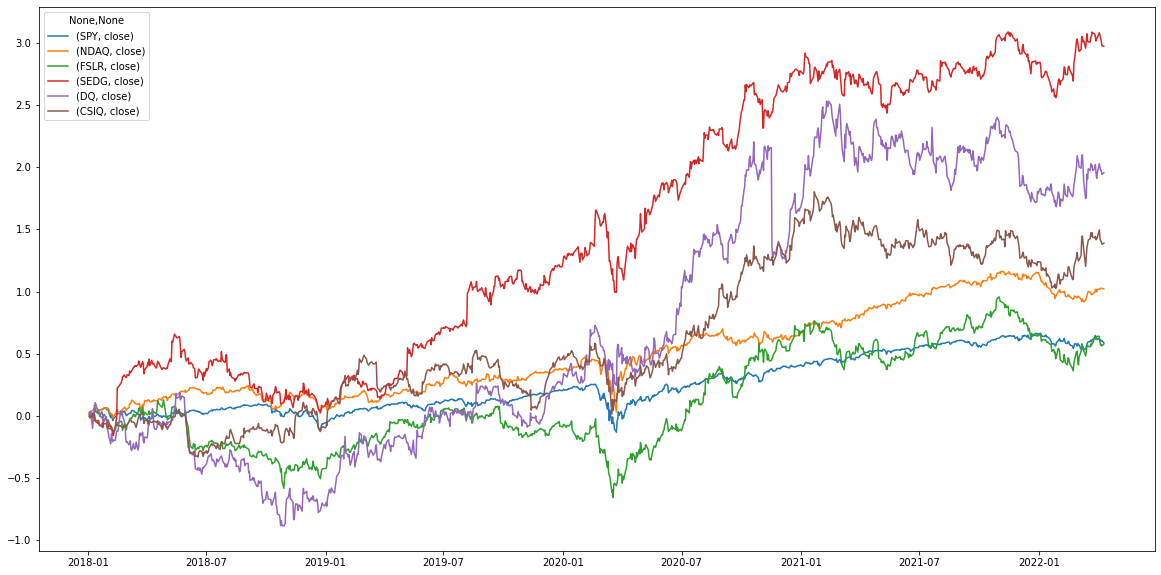

In [167]:
#Plot cummulative returns Wartime
cumulative_sum_five_years = cumulative_sum_five_years.plot(figsize=(20,10))


In [168]:
# Drop SPY to calculate mean of daily returns 
daily_returns_five_years2 = daily_returns_five_years.drop(columns=['SPY', 'NDAQ'])

In [169]:
# Calculate mean of daily returns of the portfolio
daily_returns_five_years2['mean']=daily_returns_five_years2.mean(axis=1)
daily_returns_five_years2.head()

,FSLR,SEDG,DQ,CSIQ,mean
,close,close,close,close,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545


In [174]:
#Add SPY to new dataframe with mean
daily_returns_five_years3 = pd.concat([daily_returns_five_years2, daily_returns_five_years['SPY']], axis="columns", join="inner")
#Fix Headers
daily_returns_five_years3.columns=['FSLR','SEDG','DQ','CSIQ','solar_portfolio', 'SPY']
daily_returns_five_years3.head()

,FSLR,SEDG,DQ,CSIQ,solar_portfolio,SPY
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590,0.006325
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928,0.004215
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177,0.006664
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545,0.001829


In [175]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_five_years_2 = daily_returns_five_years3.cumsum()

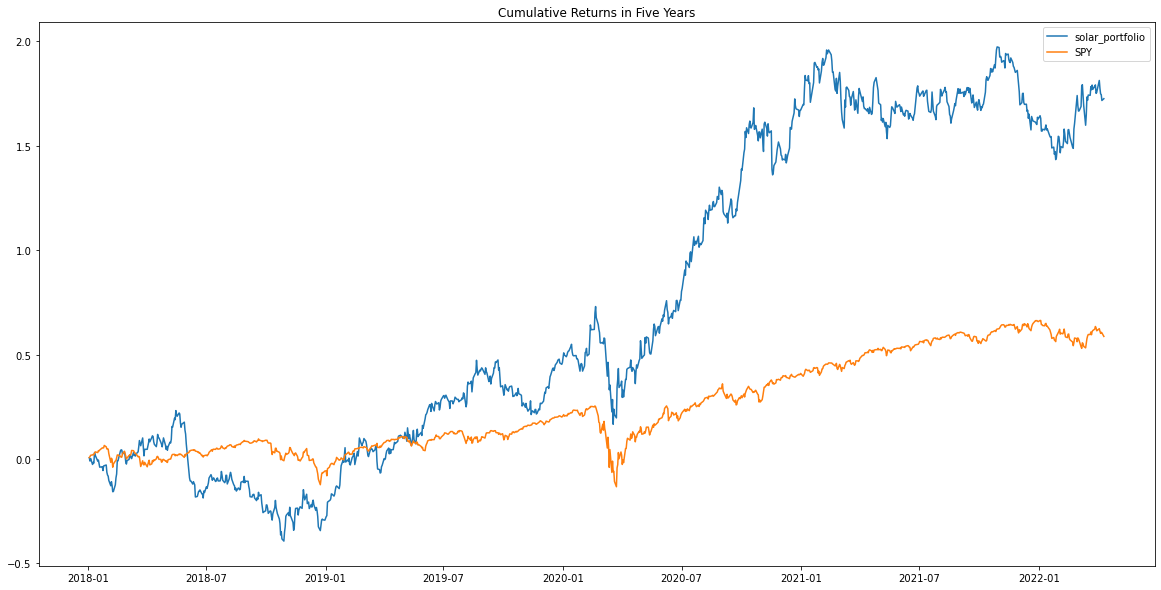

In [176]:
#Compare average cummulative performance of portfolio vs SP500 during war
avg_performance_five_years = cumulative_sum_five_years_2[['solar_portfolio', 'SPY']].plot(figsize=(20,10), title="Cumulative Returns in Five Years")

<AxesSubplot:title={'center':'Stock Risk Analysis'}>

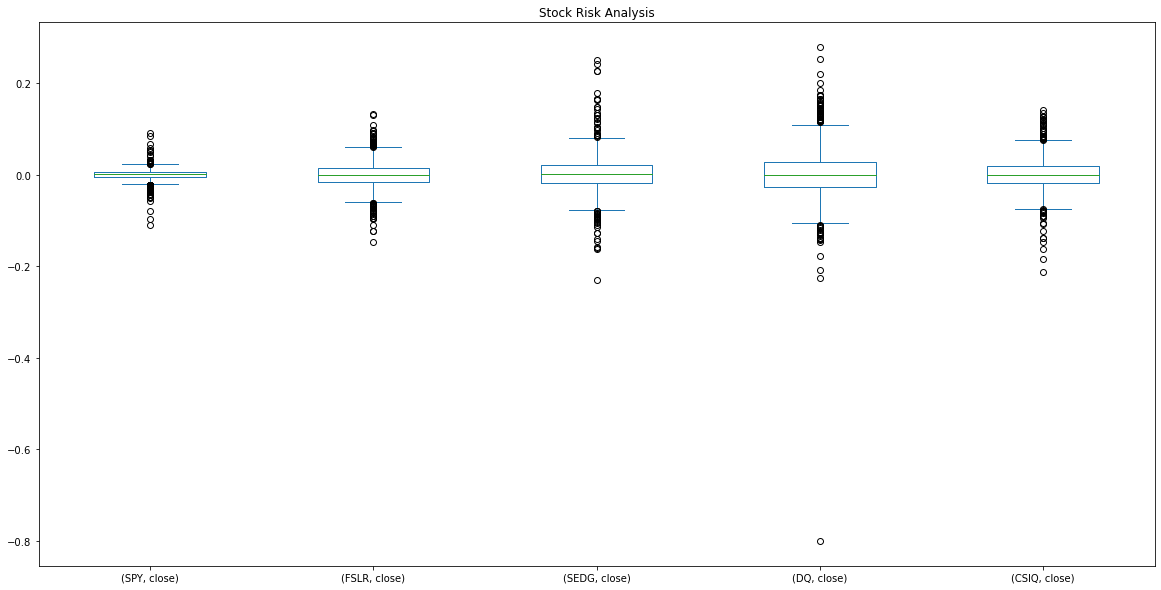

In [86]:
# Box plot to visually show risk
daily_returns_five_years.plot.box(figsize=(20, 10), title="Stock Risk Analysis")

In [87]:
# Calculate  the daily standard deviation of S&P 500 during the last five years
sp500_std_five_years= daily_returns_five_years['SPY'].std()
sp500_std_five_years

close    0.013165
dtype: float64

In [88]:
# Calculate Standard Deviations War
daily_returns_std_five_years = daily_returns_five_years.std()
daily_returns_std_five_years

SPY   close    0.013165
FSLR  close    0.029358
SEDG  close    0.041394
DQ    close    0.058893
CSIQ  close    0.036097
dtype: float64

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

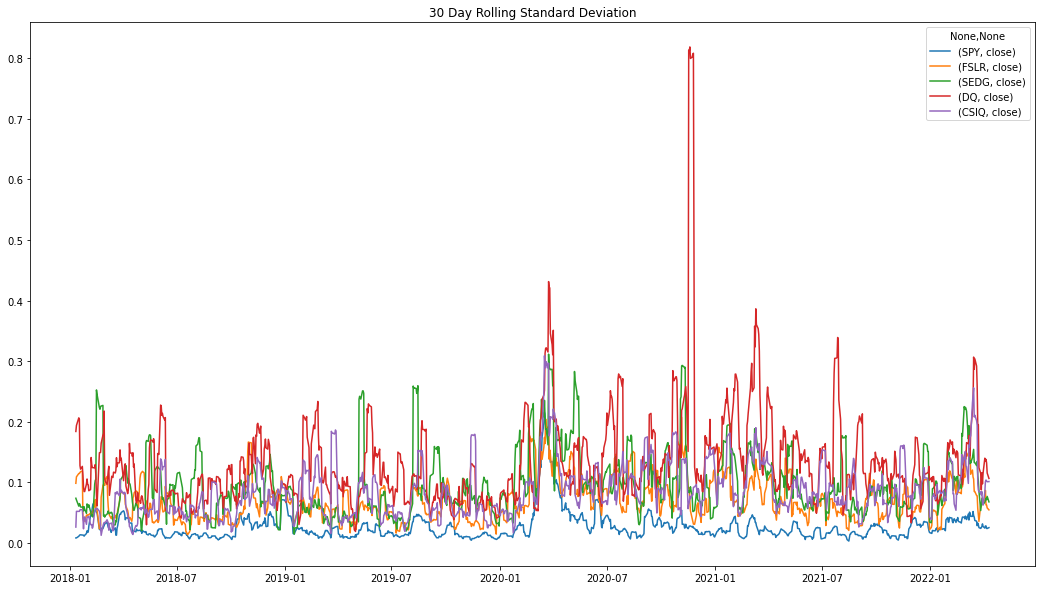

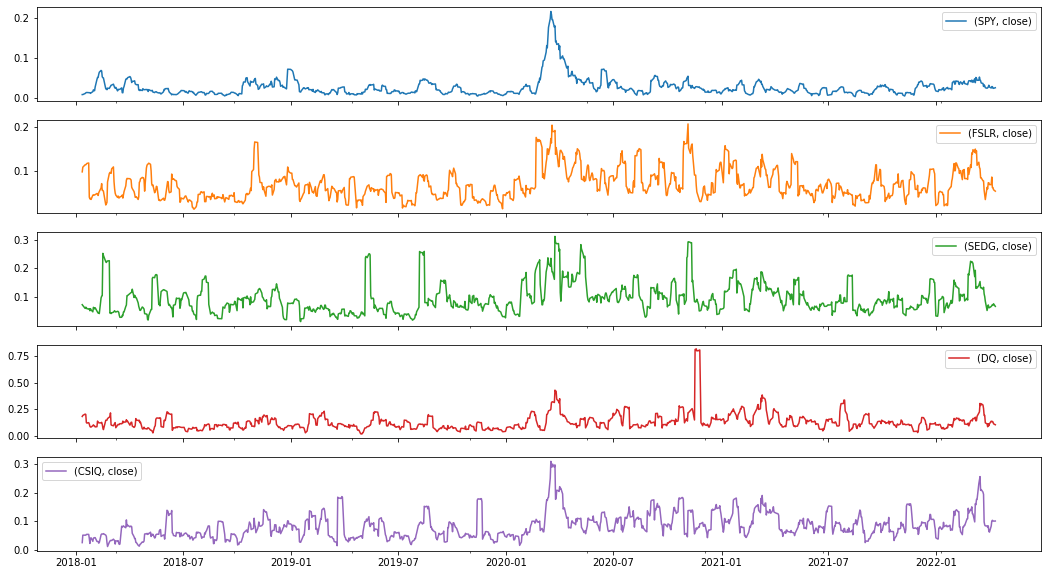

In [89]:
#Moving average for each time period of 30 days for the last five years using rolling standard deviation 
returns_five_years_std = daily_returns_five_years.rolling(7).std()*np.sqrt(7)
returns_five_years_std.plot(figsize = (18, 10), title="30 Day Rolling Standard Deviation")
returns_five_years_std.plot(figsize = (18, 10), subplots=True)

### Wartime Feb 2022 to April 2022

In [90]:
start_date_war = '2022-02-20'
end_date_war = '2022-04-11'

tickers_data_wartime = get_tickers_data(tickers, start_date_war, end_date_war, timeframe) 

tickers_data_wartime.head()

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2022-02-22,429.57,65.85,246.07,38.03,26.52
2022-02-23,422.07,64.90,236.11,39.09,26.63
2022-02-24,428.30,69.04,271.19,41.68,29.10
2022-02-25,437.75,70.68,277.93,42.92,29.84
2022-02-28,436.63,75.29,319.42,47.96,31.66


In [91]:
# obtain daily returns Wartime
daily_returns_war = tickers_data_wartime.pct_change()
daily_returns_war.head()

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2022-02-22,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.017459,-0.014427,-0.040476,0.027873,0.004148
2022-02-24,0.014761,0.063790,0.148575,0.066257,0.092753
2022-02-25,0.022064,0.023754,0.024853,0.029750,0.025430
2022-02-28,-0.002559,0.065224,0.149282,0.117428,0.060992


In [92]:
#Calculate cummulative returns Wartime
cumulative_sum_war = daily_returns_war.cumsum()

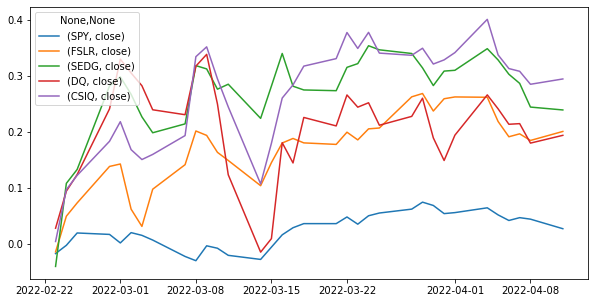

In [93]:
#Plot cummulative returns Wartime
cumulative_sum_war = cumulative_sum_war.plot(figsize=(10,5))

In [94]:
# Drop SPY to calculate mean of daily returns during war
daily_returns_war2 = daily_returns_war.drop(columns=['SPY'])

In [95]:
# Calculate mean of daily returns of the portfolio
daily_returns_war2['mean']=daily_returns_war2.mean(axis=1)
daily_returns_war2.head()

,FSLR,SEDG,DQ,CSIQ,mean
,close,close,close,close,
2022-02-22,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.014427,-0.040476,0.027873,0.004148,-0.005721
2022-02-24,0.063790,0.148575,0.066257,0.092753,0.092844
2022-02-25,0.023754,0.024853,0.029750,0.025430,0.025947
2022-02-28,0.065224,0.149282,0.117428,0.060992,0.098231


In [96]:
#Add SPY to new dataframe with mean
daily_returns_war_3 = pd.concat([daily_returns_war2,daily_returns_war['SPY']], axis="columns", join="inner")
daily_returns_war_3.head()

,"(FSLR, close)","(SEDG, close)","(DQ, close)","(CSIQ, close)","(mean, )",close
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.014427,-0.040476,0.027873,0.004148,-0.005721,-0.017459
2022-02-24,0.063790,0.148575,0.066257,0.092753,0.092844,0.014761
2022-02-25,0.023754,0.024853,0.029750,0.025430,0.025947,0.022064
2022-02-28,0.065224,0.149282,0.117428,0.060992,0.098231,-0.002559


In [97]:
#Fix Headers
daily_returns_war_3.columns=['FSLR','SEDG','DQ','CSIQ','mean','SPY']
daily_returns_war_3.head()

,FSLR,SEDG,DQ,CSIQ,mean,SPY
2022-02-22,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-23,-0.014427,-0.040476,0.027873,0.004148,-0.005721,-0.017459
2022-02-24,0.063790,0.148575,0.066257,0.092753,0.092844,0.014761
2022-02-25,0.023754,0.024853,0.029750,0.025430,0.025947,0.022064
2022-02-28,0.065224,0.149282,0.117428,0.060992,0.098231,-0.002559


In [98]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_war_2 = daily_returns_war_3.cumsum()

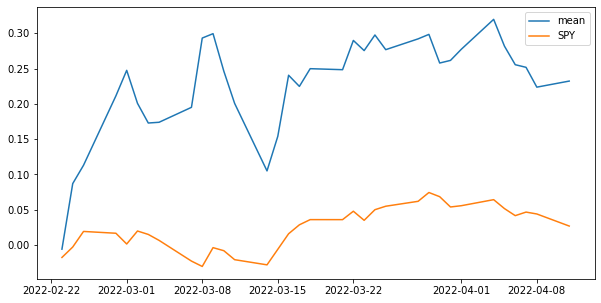

In [99]:
#Compare average cummulative performance of portfolio vs SP500 during war
avg_performance_war=cumulative_sum_war_2[['mean', 'SPY']].plot(figsize=(10,5))

In [100]:
# Calculate  the daily standard deviation of S&P 500 during wartime
sp500_std_war= daily_returns_war['SPY'].std()
sp500_std_war

close    0.013896
dtype: float64

In [101]:
# Calculate Standard Deviations War
daily_returns_std_war= daily_returns_war.std()
daily_returns_std_war

SPY   close    0.013896
FSLR  close    0.034988
SEDG  close    0.050738
DQ    close    0.065612
CSIQ  close    0.052099
dtype: float64

In [102]:
# Determine which stocks are riskier than the S&P 500 during war
#war_risk_analysis = daily_returns_std_war > sp500_std_war

<AxesSubplot:>

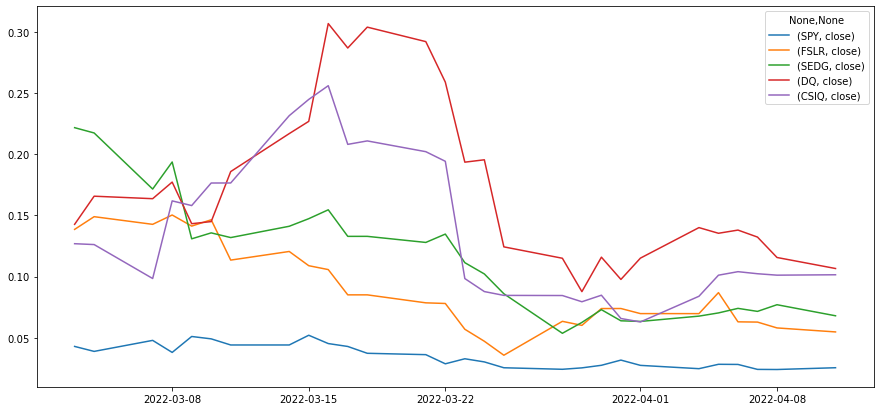

In [103]:
#Moving average for each time period of 7 days for the wartime period(shorter time frame)using rolling standard deviation 
returns_war_std = daily_returns_war.rolling(7).std()*np.sqrt(7)
returns_war_std.plot(figsize = (15, 7))

## Covid Time (Jan 2020 to Feb 2022)

In [104]:
# COVID time frame (~2 years)
start_date_covid = '2020-01-01'
end_date_covid = '2022-02-19'
tickers_data_covid = get_tickers_data(tickers, start_date_covid, end_date_covid, timeframe) 

In [105]:
#table= pd.pivot_table(yearly, values = 'close', index = [yearly.index], columns = ['symbol'])))
tickers_data_covid.head()

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2020-01-02,324.87,57.24,101.81,54.98,22.520
2020-01-03,322.41,57.02,102.38,54.45,21.800
2020-01-06,323.64,55.83,99.63,53.85,22.320
2020-01-07,322.73,56.67,101.79,53.36,22.355
2020-01-08,324.45,56.70,104.16,54.38,22.570


In [107]:
#Calculate daily returns covid
daily_returns_covid = tickers_data_covid.pct_change()
daily_returns_covid

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.007572,-0.003843,0.005599,-0.009640,-0.031972
2020-01-06,0.003815,-0.020870,-0.026861,-0.011019,0.023853
2020-01-07,-0.002812,0.015046,0.021680,-0.009099,0.001568
2020-01-08,0.005330,0.000529,0.023283,0.019115,0.009618
...,...,...,...,...,...
2022-02-14,-0.003269,-0.015582,-0.003479,-0.015210,-0.008696
2022-02-15,0.016127,0.056720,0.051922,0.082199,0.072003
2022-02-16,0.001121,-0.005964,0.017394,-0.012095,0.007501


In [108]:
#Calculate cummulative returns covid
cumulative_sum_covid = daily_returns_covid.cumsum()

<AxesSubplot:>

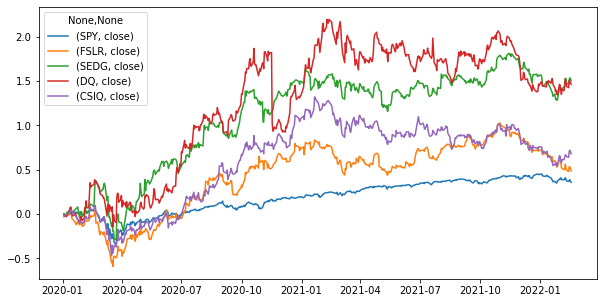

In [109]:
#Plot cummulative returns covid
cumulative_sum_covid.plot(figsize=(10,5))

In [110]:
# Drop SPY to calculate mean of daily returns
daily_returns_covid2=daily_returns_covid.drop(columns=['SPY'])

In [111]:
# Calculate mean of daily returns of the portfolio
daily_returns_covid2['mean']=daily_returns_covid2.mean(axis=1)
daily_returns_covid2

,FSLR,SEDG,DQ,CSIQ,mean
,close,close,close,close,
2020-01-02,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003843,0.005599,-0.009640,-0.031972,-0.009964
2020-01-06,-0.020870,-0.026861,-0.011019,0.023853,-0.008724
2020-01-07,0.015046,0.021680,-0.009099,0.001568,0.007299
2020-01-08,0.000529,0.023283,0.019115,0.009618,0.013136
...,...,...,...,...,...
2022-02-14,-0.015582,-0.003479,-0.015210,-0.008696,-0.010742
2022-02-15,0.056720,0.051922,0.082199,0.072003,0.065711
2022-02-16,-0.005964,0.017394,-0.012095,0.007501,0.001709


In [112]:
#Add SPY to new dataframe with mean
daily_returns_covid_3 = pd.concat([daily_returns_covid2,daily_returns_covid['SPY']], axis="columns", join="inner")
daily_returns_covid_3

,"(FSLR, close)","(SEDG, close)","(DQ, close)","(CSIQ, close)","(mean, )",close
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003843,0.005599,-0.009640,-0.031972,-0.009964,-0.007572
2020-01-06,-0.020870,-0.026861,-0.011019,0.023853,-0.008724,0.003815
2020-01-07,0.015046,0.021680,-0.009099,0.001568,0.007299,-0.002812
2020-01-08,0.000529,0.023283,0.019115,0.009618,0.013136,0.005330
...,...,...,...,...,...,...
2022-02-14,-0.015582,-0.003479,-0.015210,-0.008696,-0.010742,-0.003269
2022-02-15,0.056720,0.051922,0.082199,0.072003,0.065711,0.016127
2022-02-16,-0.005964,0.017394,-0.012095,0.007501,0.001709,0.001121
2022-02-17,-0.023999,-0.012972,-0.015671,-0.018613,-0.017814,-0.021317


In [113]:
#Fix Headers
daily_returns_covid_3.columns=['FSLR','SEDG','DQ','CSIQ','mean','SPY']
daily_returns_covid_3

,FSLR,SEDG,DQ,CSIQ,mean,SPY
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.003843,0.005599,-0.009640,-0.031972,-0.009964,-0.007572
2020-01-06,-0.020870,-0.026861,-0.011019,0.023853,-0.008724,0.003815
2020-01-07,0.015046,0.021680,-0.009099,0.001568,0.007299,-0.002812
2020-01-08,0.000529,0.023283,0.019115,0.009618,0.013136,0.005330
...,...,...,...,...,...,...
2022-02-14,-0.015582,-0.003479,-0.015210,-0.008696,-0.010742,-0.003269
2022-02-15,0.056720,0.051922,0.082199,0.072003,0.065711,0.016127
2022-02-16,-0.005964,0.017394,-0.012095,0.007501,0.001709,0.001121
2022-02-17,-0.023999,-0.012972,-0.015671,-0.018613,-0.017814,-0.021317


In [114]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_covid_3 = daily_returns_covid_3.cumsum()

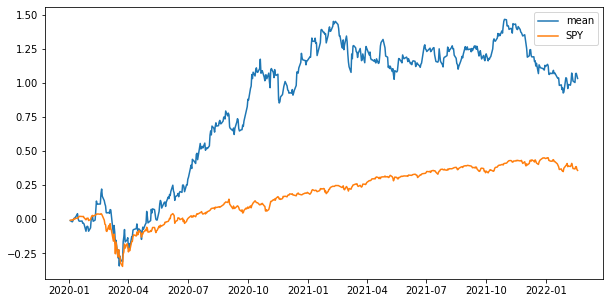

In [115]:
#Compare average cummulative performance of portfolio vs SP500
avg_performance_covid=cumulative_sum_covid_3[['mean', 'SPY']].plot(figsize=(10,5))

In [116]:
# Calculate the daily standard deviation of S&P 500 during covid
sp500_std_covid= daily_returns_covid['SPY'].std()
sp500_std_covid

close    0.015841
dtype: float64

In [117]:
# Calculate Standard Deviations covid
daily_returns_std_covid= daily_returns_covid.std()
daily_returns_std_covid

SPY   close    0.015841
FSLR  close    0.033713
SEDG  close    0.046084
DQ    close    0.070248
CSIQ  close    0.040789
dtype: float64

In [118]:
# Determine which stocks are riskier than the S&P 500 during covid
#covid_risk_analysis = daily_returns_std_covid > sp500_std_covid

<AxesSubplot:>

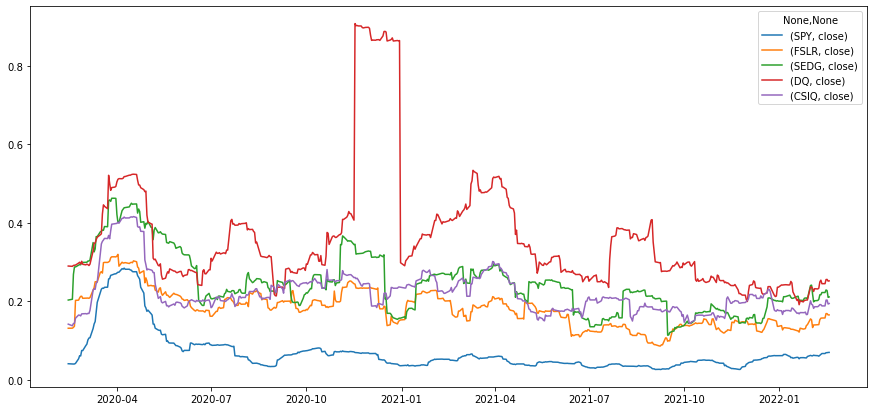

In [119]:
#Moving average for each time period of 30 days using rolling standard deviation 
returns_covid_std = daily_returns_covid.rolling(30).std()*np.sqrt(30)
returns_covid_std.plot(figsize = (15, 7))

## Pre Covid time (Jan 2018 to Dec 2019)

In [121]:
# pre-Covid time frame (2 years)
start_date_pre_covid = '2018-01-01'
end_date_pre_covid = '2019-12-31'
tickers_data_pre_covid = get_tickers_data(tickers, start_date_pre_covid, end_date_pre_covid, timeframe) 

In [122]:
tickers_data_pre_covid

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2018-01-02,268.77,70.43,38.05,62.57,17.14
2018-01-03,270.47,69.80,39.05,63.14,17.07
2018-01-04,271.61,69.14,37.35,62.50,17.06
2018-01-05,273.42,69.17,37.90,64.78,17.01
2018-01-08,273.92,69.62,38.35,55.85,17.10
...,...,...,...,...,...
2019-12-24,321.23,57.98,95.20,51.64,22.15
2019-12-26,322.94,58.66,95.56,51.51,22.32
2019-12-27,322.86,56.41,94.26,51.64,21.79


In [123]:
#Calculate daily returns pre covid
daily_returns_pre_covid = tickers_data_pre_covid.pct_change()
daily_returns_pre_covid

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.006506,0.011873,-0.137851,0.005291
...,...,...,...,...,...
2019-12-24,0.000031,0.002074,0.010830,0.011954,0.015589
2019-12-26,0.005323,0.011728,0.003782,-0.002517,0.007675
2019-12-27,-0.000248,-0.038357,-0.013604,0.002524,-0.023746


In [124]:
#Calculate cummulative returns Pre-Covid
Cumulative_Sum3 = daily_returns_pre_covid.cumsum()

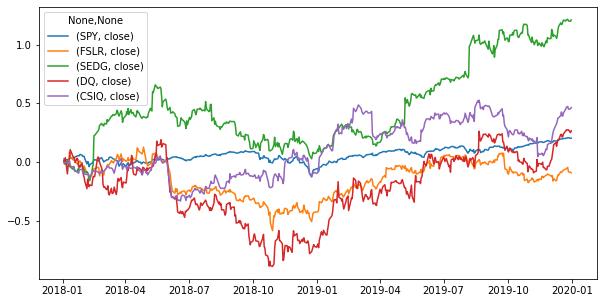

In [125]:
#Plot Cummulative Returns Pre-Covid
cumulative_returns_pre_covid=Cumulative_Sum3.plot(figsize=(10,5))

In [126]:
# Calculate  the daily standard deviation of S&P 500 during wartime
sp500_std= tickers_data_wartime['SPY'].std()
sp500_std

close    12.861764
dtype: float64

In [127]:
# Calculate Standard Deviations War
returns_std_war= tickers_data_wartime.std()
returns_std_war

SPY   close    12.861764
FSLR  close     5.180419
SEDG  close    23.409438
DQ    close     4.007627
CSIQ  close     3.007649
dtype: float64

## Pre Covid time (Jan 2018 to Dec 2019)

In [128]:
# pre-Covid time frame (2 years)
start_date_pre_covid = '2018-01-01'
end_date_pre_covid = '2019-12-31'
tickers_data_pre_covid = get_tickers_data(tickers, start_date_pre_covid, end_date_pre_covid, timeframe) 

In [129]:
tickers_data_pre_covid

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2018-01-02,268.77,70.43,38.05,62.57,17.14
2018-01-03,270.47,69.80,39.05,63.14,17.07
2018-01-04,271.61,69.14,37.35,62.50,17.06
2018-01-05,273.42,69.17,37.90,64.78,17.01
2018-01-08,273.92,69.62,38.35,55.85,17.10
...,...,...,...,...,...
2019-12-24,321.23,57.98,95.20,51.64,22.15
2019-12-26,322.94,58.66,95.56,51.51,22.32
2019-12-27,322.86,56.41,94.26,51.64,21.79


In [130]:
#Calculate daily returns pre covid
daily_returns_pre_covid = tickers_data_pre_covid.pct_change()
daily_returns_pre_covid

,SPY,FSLR,SEDG,DQ,CSIQ
,close,close,close,close,close
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.006325,-0.008945,0.026281,0.009110,-0.004084
2018-01-04,0.004215,-0.009456,-0.043534,-0.010136,-0.000586
2018-01-05,0.006664,0.000434,0.014726,0.036480,-0.002931
2018-01-08,0.001829,0.006506,0.011873,-0.137851,0.005291
...,...,...,...,...,...
2019-12-24,0.000031,0.002074,0.010830,0.011954,0.015589
2019-12-26,0.005323,0.011728,0.003782,-0.002517,0.007675
2019-12-27,-0.000248,-0.038357,-0.013604,0.002524,-0.023746


In [131]:
#Calculate cummulative returns Pre-Covid
Cumulative_Sum3 = daily_returns_pre_covid.cumsum()

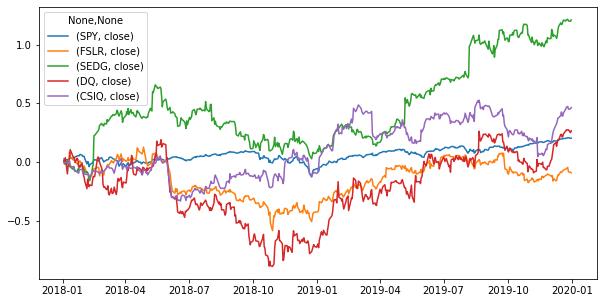

In [132]:
#Plot Cummulative Returns Pre-Covid
cumulative_returns_pre_covid=Cumulative_Sum3.plot(figsize=(10,5))

In [133]:
# Drop SPY to calculate mean of daily returns pre-covid
daily_returns_pre_covid2=daily_returns_pre_covid.drop(columns=['SPY'])

In [134]:
# Calculate mean of daily returns of the portfolio
daily_returns_pre_covid2['mean']=daily_returns_pre_covid2.mean(axis=1)
daily_returns_pre_covid2

,FSLR,SEDG,DQ,CSIQ,mean
,close,close,close,close,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545
...,...,...,...,...,...
2019-12-24,0.002074,0.010830,0.011954,0.015589,0.010112
2019-12-26,0.011728,0.003782,-0.002517,0.007675,0.005167
2019-12-27,-0.038357,-0.013604,0.002524,-0.023746,-0.018296


In [135]:
#Add SPY to new dataframe with mean
daily_returns_pre_covid_3 = pd.concat([daily_returns_pre_covid2,daily_returns_pre_covid['SPY']], axis="columns", join="inner")
daily_returns_pre_covid_3

,"(FSLR, close)","(SEDG, close)","(DQ, close)","(CSIQ, close)","(mean, )",close
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590,0.006325
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928,0.004215
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177,0.006664
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545,0.001829
...,...,...,...,...,...,...
2019-12-24,0.002074,0.010830,0.011954,0.015589,0.010112,0.000031
2019-12-26,0.011728,0.003782,-0.002517,0.007675,0.005167,0.005323
2019-12-27,-0.038357,-0.013604,0.002524,-0.023746,-0.018296,-0.000248
2019-12-30,-0.002659,-0.002758,-0.024787,0.003212,-0.006748,-0.005513


In [136]:
#Fix Headers
daily_returns_pre_covid_3.columns=['FSLR', 'SEDG','DQ','CSIQ','mean','SPY']
daily_returns_pre_covid_3

,FSLR,SEDG,DQ,CSIQ,mean,SPY
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.008945,0.026281,0.009110,-0.004084,0.005590,0.006325
2018-01-04,-0.009456,-0.043534,-0.010136,-0.000586,-0.015928,0.004215
2018-01-05,0.000434,0.014726,0.036480,-0.002931,0.012177,0.006664
2018-01-08,0.006506,0.011873,-0.137851,0.005291,-0.028545,0.001829
...,...,...,...,...,...,...
2019-12-24,0.002074,0.010830,0.011954,0.015589,0.010112,0.000031
2019-12-26,0.011728,0.003782,-0.002517,0.007675,0.005167,0.005323
2019-12-27,-0.038357,-0.013604,0.002524,-0.023746,-0.018296,-0.000248
2019-12-30,-0.002659,-0.002758,-0.024787,0.003212,-0.006748,-0.005513


In [137]:
#Calculate cummulative Sum to plot mean vs SPY during war
cumulative_sum_pre_covid_3 = daily_returns_pre_covid_3.cumsum()

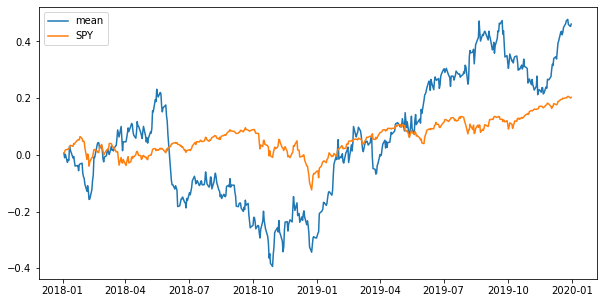

In [138]:
#Compare average cummulative performance of portfolio vs SP500
avg_performance_covid = cumulative_sum_pre_covid_3[['mean', 'SPY']].plot(figsize=(10,5))

In [139]:
# Calculate the daily standard deviation of S&P 500 pre covid

sp500_std_pre_covid= daily_returns_pre_covid['SPY'].std()
sp500_std_covid

close    0.015841
dtype: float64

In [140]:
# Calculate Standard Deviations covid
daily_returns_std_pre_covid= daily_returns_pre_covid.std()
daily_returns_std_pre_covid

SPY   close    0.009473
FSLR  close    0.023316
SEDG  close    0.034862
DQ    close    0.043036
CSIQ  close    0.028642
dtype: float64

In [141]:
# Determine which stocks are riskier than the S&P 500 during covid
#risk_analysis = daily_returns_std_pre_covid > sp500_std_pre_covid

<AxesSubplot:>

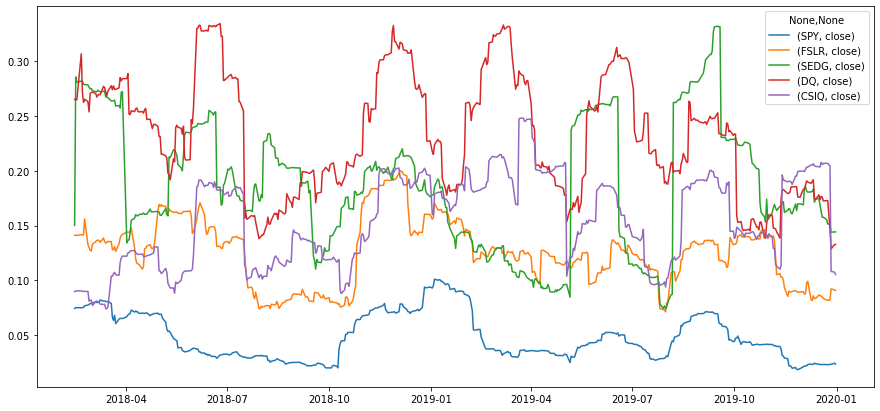

In [142]:
returns_pre_covid_std = daily_returns_pre_covid.rolling(30).std()*np.sqrt(30)
returns_pre_covid_std.plot(figsize = (15, 7))

## Monte Carlo Simulation (from the past 5 years)

In [179]:
#Prepping 5 year data for Monte Carlo simulation 
start_date_renewable = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()
end_date_renewable = pd.Timestamp('2022-04-11', tz='America/New_York').isoformat()

tickers_renew_energy = ['FSLR' , 'SEDG', 'DQ', 'CSIQ']
timeframe='1Day'

green_portfolio_df = alpaca.get_bars(
    tickers_renew_energy,
    timeframe,
    start=start_date_renewable,
    end=end_date_renewable
).df

FSLR = green_portfolio_df[green_portfolio_df['symbol']=='FSLR'].drop('symbol', axis = 1)
SEDG = green_portfolio_df[green_portfolio_df['symbol']=='SEDG'].drop('symbol', axis = 1)
DQ = green_portfolio_df[green_portfolio_df['symbol']=='DQ'].drop('symbol', axis = 1)
CSIQ = green_portfolio_df[green_portfolio_df['symbol']=='CSIQ'].drop('symbol', axis = 1)

five_year_green_df = pd.concat([FSLR, SEDG, DQ, CSIQ], axis=1, keys= ['FSLR', 'SEDG', 'DQ', 'CSIQ'])

#five_year_renew_energy = get_tickers_data(tickers_renew_energy, start_date_renewable, end_date_renewable, timeframe)
#five_year_renew_energy.set_index(five_year_renew_energy['Date'])
#five_year_renew_energy = pd.to_datetime(five_year_renew_energy.index)
five_year_green_df

FSLR                                            \
                            open   high    low  close   volume trade_count   
timestamp                                                                    
2018-01-02 05:00:00+00:00  67.84  70.50  67.84  70.43  1752173       13453   
2018-01-03 05:00:00+00:00  70.87  71.59  69.02  69.80  1923969       16097   
2018-01-04 05:00:00+00:00  70.00  70.20  66.20  69.14  3032663       19854   
2018-01-05 05:00:00+00:00  69.00  69.59  68.25  69.17  1021405        9996   
2018-01-08 05:00:00+00:00  69.25  70.13  67.70  69.62  1067348        8783   
...                          ...    ...    ...    ...      ...         ...   
2022-04-05 04:00:00+00:00  81.40  82.92  79.83  80.33  2516390       34020   
2022-04-06 04:00:00+00:00  79.13  79.99  77.41  78.13  1263982       23967   
2022-04-07 04:00:00+00:00  78.26  79.90  77.07  78.54   937485       18850   
2022-04-08 04:00:00+00:00  78.38  79.43  76.95  77.61   889824       18794   
2022-04-11 04:00:00+00:00  76.65  80.37  76.25  78.86  1309313       23874   

                                        SEDG                    ...       DQ  \
                                vwap    open      high     low  ...   volume   
timestamp                                                       ...            
2018-01-02 05:00:00+00:00  69.736077   37.65   38.2000   37.35  ...   390947   
2018-01-03 05:00:00+00:00  69.996869   38.25   39.1500   37.85  ...   347190   
2018-01-04 05:00:00+00:00  67.859662   39.55   39.6500   36.45  ...   216966   
2018-01-05 05:00:00+00:00  69.043410   37.35   38.3750   37.15  ...   219312   
2018-01-08 05:00:00+00:00  69.167618   38.00   38.5233   37.75  ...  1488651   
...                              ...     ...       ...     ...  ...      ...   
2022-04-05 04:00:00+00:00  80.964468  337.36  344.6100  323.16  ...  1461995   
2022-04-06 04:00:00+00:00  78.199861  322.00  327.0000  311.62  ...  1661379   
2022-04-07 04:00:00+00:00  78.374722  319.57  329.2900  309.06  ...  1372471   
2022-04-08 04:00:00+00:00  77.871387  312.93  313.9000  299.29  ...  1441369   
2022-04-11 04:00:00+00:00  78.729417  299.49  305.7200  291.96  ...  1305069   

                                                   CSIQ                    \
                          trade_count       vwap   open     high      low   
timestamp                                                                   
2018-01-02 05:00:00+00:00        3440  62.483720  16.98  17.1600  16.8800   
2018-01-03 05:00:00+00:00        3325  63.128077  17.18  17.2000  16.8348   
2018-01-04 05:00:00+00:00        2087  63.043726  17.13  17.1600  16.7800   
2018-01-05 05:00:00+00:00        2107  64.644756  17.00  17.1900  16.9000   
2018-01-08 05:00:00+00:00       10612  55.766221  17.03  17.2000  16.8500   
...                               ...        ...    ...      ...      ...   
2022-04-05 04:00:00+00:00       12172  45.271965  38.43  38.4300  35.3000   
2022-04-06 04:00:00+00:00       12471  43.599838  35.00  35.4650  34.0300   
2022-04-07 04:00:00+00:00       10584  44.048660  34.70  35.1499  33.4650   
2022-04-08 04:00:00+00:00       12125  43.014384  34.24  34.9200  33.5100   
2022-04-11 04:00:00+00:00       10877  43.136785  33.57  34.6300  33.2500   

                                                                  
                           close   volume trade_count       vwap  
timestamp                                                         
2018-01-02 05:00:00+00:00  17.14   736138        4712  17.076758  
2018-01-03 05:00:00+00:00  17.07   987611        4674  17.036264  
2018-01-04 05:00:00+00:00  17.06   799063        4740  16.950192  
2018-01-05 05:00:00+00:00  17.01   768883        4063  17.060800  
2018-01-08 05:00:00+00:00  17.10   727053        4153  17.069678  
...                          ...      ...         ...        ...  
2022-04-05 04:00:00+00:00  35.54   835599       13536  36.336234  
2022-04-06 04:00:00+00:00  34.67   614077       11614  34.564883 

In [178]:
#Prepping 5 year data for Monte Carlo simulation 
start_date_spy = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()
end_date_spy = pd.Timestamp('2022-04-11', tz='America/New_York').isoformat()

tickers_spy = ['SPY']
timeframe='1Day'

spy_portfolio_df = alpaca.get_bars(
    tickers_spy,
    timeframe,
    start=start_date_spy,
    end=end_date_spy
).df

#five_year_renew_energy = get_tickers_data(tickers_renew_energy, start_date_renewable, end_date_renewable, timeframe)
#five_year_renew_energy.set_index(five_year_renew_energy['Date'])
#five_year_renew_energy = pd.to_datetime(five_year_renew_energy.index)
spy_portfolio_df.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2018-01-02 05:00:00+00:00,267.86,268.81,267.4000,268.77,87130750,233353,268.228135,SPY
2018-01-03 05:00:00+00:00,268.99,270.64,268.9600,270.47,90658541,233673,269.903535,SPY
2018-01-04 05:00:00+00:00,271.22,272.16,270.5447,271.61,83813282,206556,271.628213,SPY
2018-01-05 05:00:00+00:00,272.56,273.56,271.9500,273.42,85250827,208413,272.850434,SPY
2018-01-08 05:00:00+00:00,273.32,274.10,272.9800,273.92,57580592,150234,273.764418,SPY


In [111]:
#Monte Carlo simulation for future return predicitions 
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

In [147]:
MC_thirtyyear_renew = MCSimulation(
    portfolio_data = five_year_green_df,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

MC_thirtyyear_renew.portfolio_data.head()

FSLR                                            \
                            open   high    low  close   volume trade_count   
timestamp                                                                    
2018-01-02 05:00:00+00:00  67.84  70.50  67.84  70.43  1752173       13453   
2018-01-03 05:00:00+00:00  70.87  71.59  69.02  69.80  1923969       16097   
2018-01-04 05:00:00+00:00  70.00  70.20  66.20  69.14  3032663       19854   
2018-01-05 05:00:00+00:00  69.00  69.59  68.25  69.17  1021405        9996   
2018-01-08 05:00:00+00:00  69.25  70.13  67.70  69.62  1067348        8783   

                                                    SEDG           ...  \
                                vwap daily_return   open     high  ...   
timestamp                                                          ...   
2018-01-02 05:00:00+00:00  69.736077          NaN  37.65  38.2000  ...   
2018-01-03 05:00:00+00:00  69.996869    -0.008945  38.25  39.1500  ...   
2018-01-04 05:00:00+00:00  67.859662    -0.009456  39.55  39.6500  ...   
2018-01-05 05:00:00+00:00  69.043410     0.000434  37.35  38.3750  ...   
2018-01-08 05:00:00+00:00  69.167618     0.006506  38.00  38.5233  ...   

                                  DQ                CSIQ                  \
                                vwap daily_return   open   high      low   
timestamp                                                                  
2018-01-02 05:00:00+00:00  62.483720          NaN  16.98  17.16  16.8800   
2018-01-03 05:00:00+00:00  63.128077     0.009110  17.18  17.20  16.8348   
2018-01-04 05:00:00+00:00  63.043726    -0.010136  17.13  17.16  16.7800   
2018-01-05 05:00:00+00:00  64.644756     0.036480  17.00  17.19  16.9000   
2018-01-08 05:00:00+00:00  55.766221    -0.137851  17.03  17.20  16.8500   

                                                                              
                           close  volume trade_count       vwap daily_return  
timestamp                                                                     
2018-01-02 05:00:00+00:00  17.14  736138        4712  17.076758          NaN  
2018-01-03 05:00:00+00:00  17.07  987611        4674  17.036264    -0.004084  
2018-01-04 05:00:00+00:00  17.06  799063        4740  16.950192    -0.000586  
2018-01-05 05:00:00+00:00  17.01  768883        4063  17.060800    -0.002931  
2018-01-08 05:00:00+00:00  17.10  727053        4153  17.069678     0.005291  

[5 rows x 32 columns]

In [149]:
MC_thirtyyear_renew.calc_cumulative_return()

Running Monte Carlo simulation number 0.


ValueError: Dot product shape mismatch, (7561, 4) vs (2,)

In [150]:
line_plot = MC_thirtyyear_renew.plot_simulation()

Running Monte Carlo simulation number 0.


ValueError: Dot product shape mismatch, (7561, 4) vs (2,)

In [115]:
MC_thirtyyear_spy = MCSimulation(
    portfolio_data = five_year_spy,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

MC_thirtyyear_spy.portfolio_data.head()

SPY             
             close daily_return
2018-01-02  268.77          NaN
2018-01-03  270.47     0.006325
2018-01-04  271.61     0.004215
2018-01-05  273.42     0.006664
2018-01-08  273.92     0.001829

In [116]:
MC_thirtyyear_spy.calc_cumulative_return()

Running Monte Carlo simulation number 0.


ValueError: Dot product shape mismatch, (7561, 1) vs (2,)

In [117]:
line_plot = MC_thirtyyear_spy.plot_simulation()

Running Monte Carlo simulation number 0.


ValueError: Dot product shape mismatch, (7561, 1) vs (2,)

## Visualizations (showing preformance in the past 5 years)

In [45]:
import seaborn as sns

In [64]:
def get_tickers_data1(tickers, start_date, end_date, timeframe):
    start_date = pd.Timestamp(start_date, tz = "America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz = "America/New_York").isoformat()
    tickers_data_df = alpaca.get_bars(tickers, timeframe,start_date , end_date, adjustment = 'raw').df
    tickers_data_df.index = tickers_data_df.index.date
    tickers_data_list=[]
    for ticker in tickers:
        tickers_data_list.append(tickers_data_df[tickers_data_df['symbol']==ticker].drop('symbol', axis=1))
        
    clean_tickers_data = pd.concat(tickers_data_list,axis=1, keys=tickers)
    return clean_tickers_data

In [65]:
tickers = ['SPY', 'FSLR' , 'SEDG', 'DQ', 'CSIQ']
timeframe='1Day'

start_date = '2018-01-01'
end_date = '2022-04-11'


five_year_df = get_tickers_data1(tickers, start_date, end_date, timeframe) 
five_year_df.head()

SPY                                                  \
              open    high       low   close    volume trade_count   
2018-01-02  267.86  268.81  267.4000  268.77  87130750      233353   
2018-01-03  268.99  270.64  268.9600  270.47  90658541      233673   
2018-01-04  271.22  272.16  270.5447  271.61  83813282      206556   
2018-01-05  272.56  273.56  271.9500  273.42  85250827      208413   
2018-01-08  273.32  274.10  272.9800  273.92  57580592      150234   

                         FSLR                ...       DQ              \
                  vwap   open   high    low  ...   volume trade_count   
2018-01-02  268.228135  67.84  70.50  67.84  ...   390947        3440   
2018-01-03  269.903535  70.87  71.59  69.02  ...   347190        3325   
2018-01-04  271.628213  70.00  70.20  66.20  ...   216966        2087   
2018-01-05  272.850434  69.00  69.59  68.25  ...   219312        2107   
2018-01-08  273.764418  69.25  70.13  67.70  ...  1488651       10612   

                        CSIQ                                             \
                 vwap   open   high      low  close  volume trade_count   
2018-01-02  62.483720  16.98  17.16  16.8800  17.14  736138        4712   
2018-01-03  63.128077  17.18  17.20  16.8348  17.07  987611        4674   
2018-01-04  63.043726  17.13  17.16  16.7800  17.06  799063        4740   
2018-01-05  64.644756  17.00  17.19  16.9000  17.01  768883        4063   
2018-01-08  55.766221  17.03  17.20  16.8500  17.10  727053        4153   

                       
                 vwap  
2018-01-02  17.076758  
2018-01-03  17.036264  
2018-01-04  16.950192  
2018-01-05  17.060800  
2018-01-08  17.069678  

[5 rows x 35 columns]

In [38]:
pip install plotly==5.7.0

     |████████████████████████████████| 28.8 MB 3.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [66]:
import plotly.graph_objects as go
import pandas as pd

In [67]:
five_year_df.to_csv("five_year_stock_data.csv") 

In [68]:
fig = go.Figure(five_year_df=[go.Candlestick(x=five_year_df.index,
                open=five_year_df['SPY', 'open'],
                high=five_year_df['SPY', 'high'],
                low=five_year_df['SPY', 'low'],
                close=five_year_df['SPY', 'close'])])

fig.show()

TypeError: invalid Figure property: five_year_df
five
Bad property path:
five_year_df
^^^^